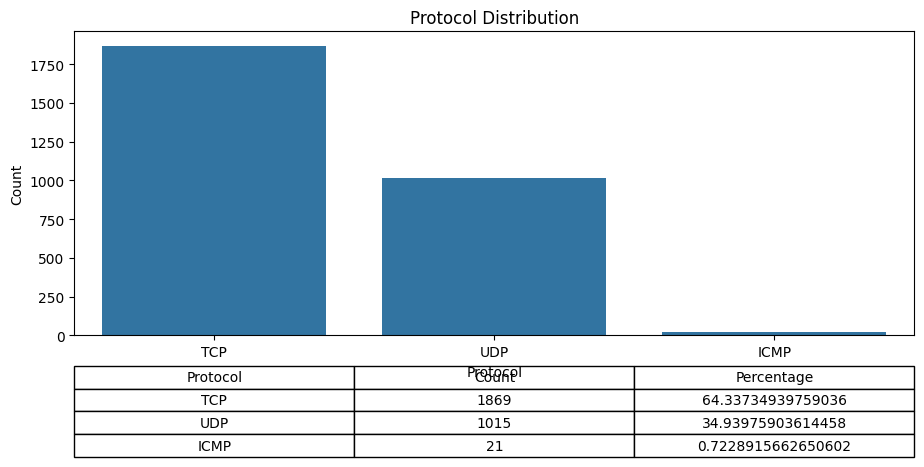

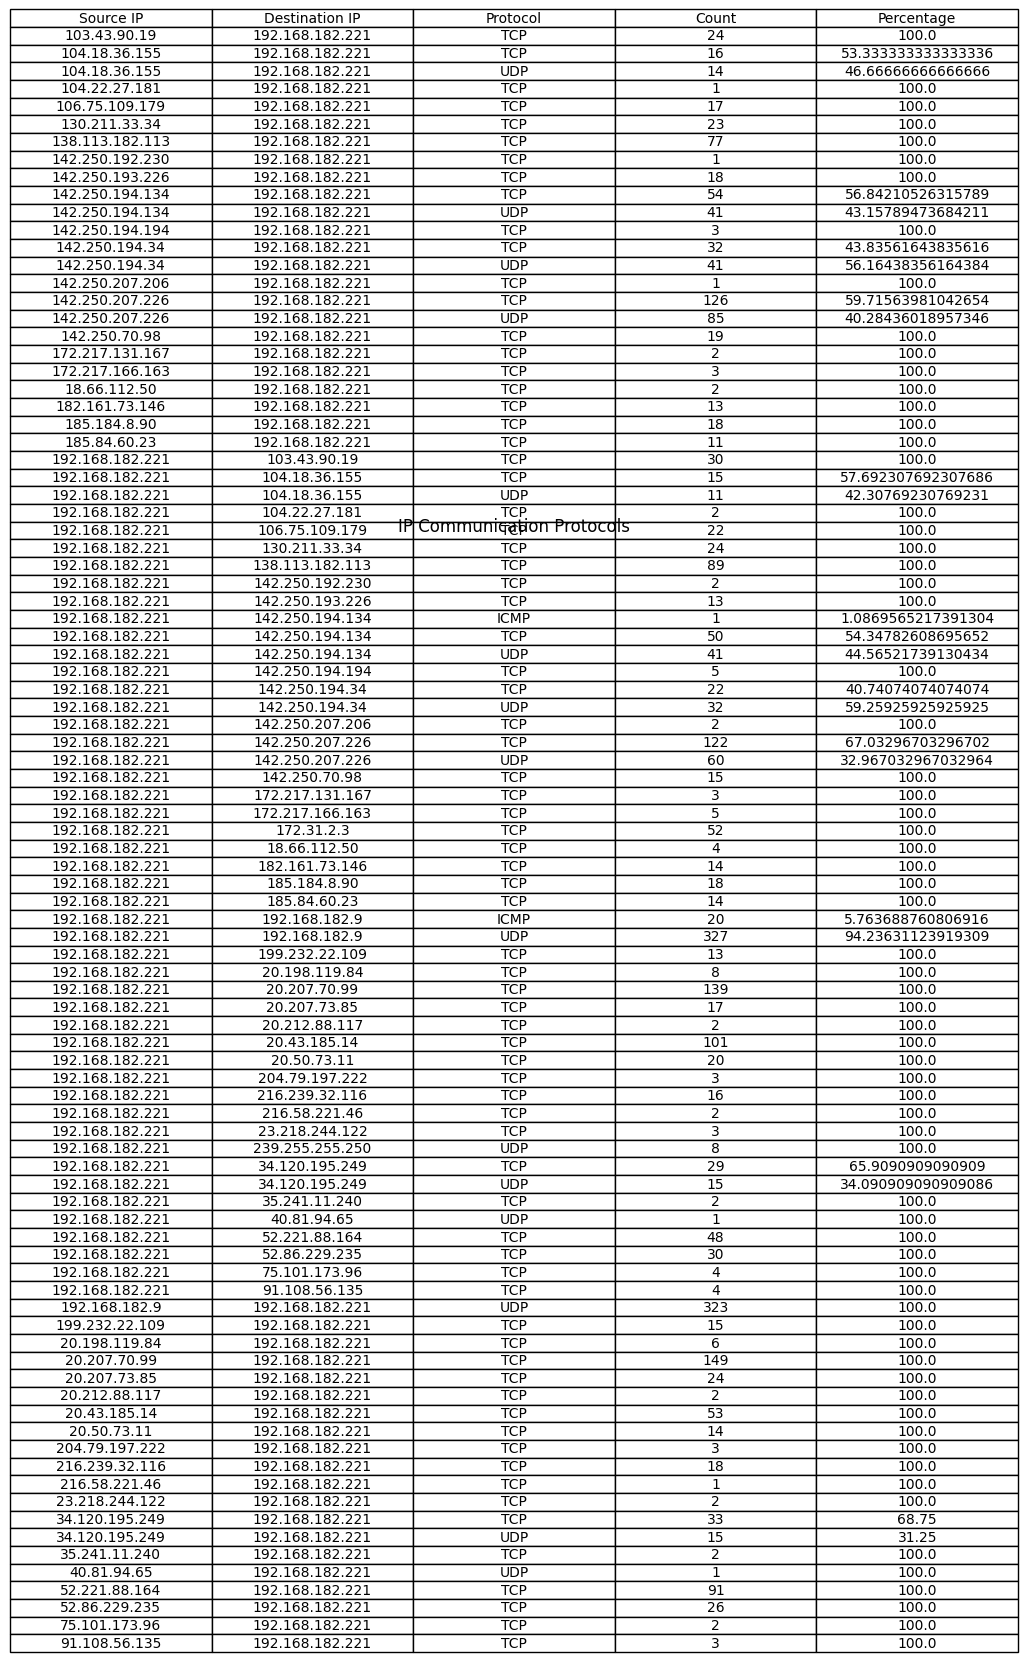

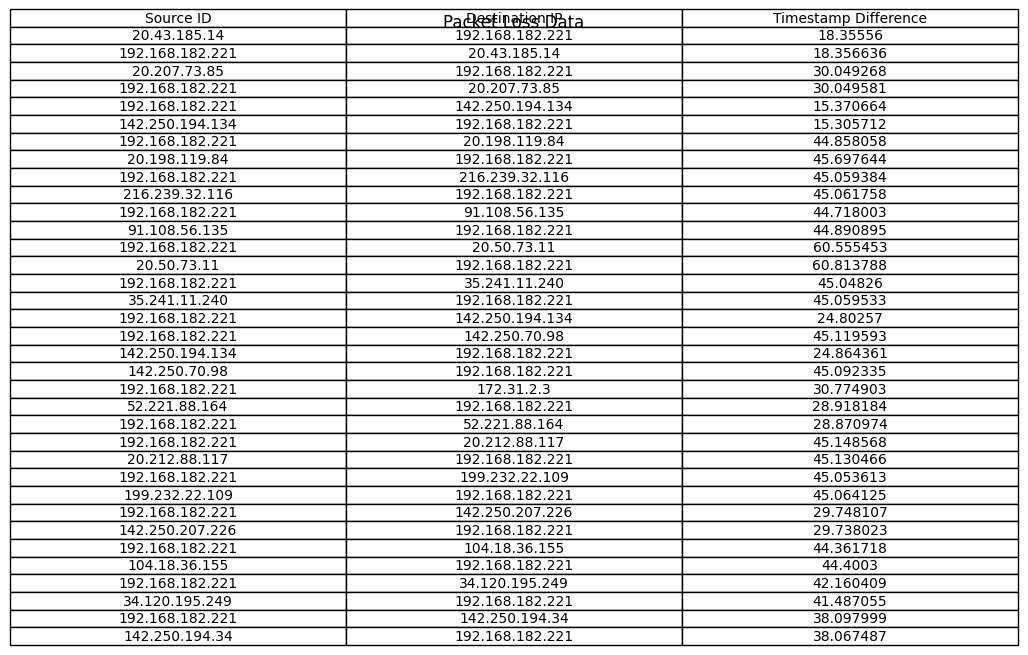

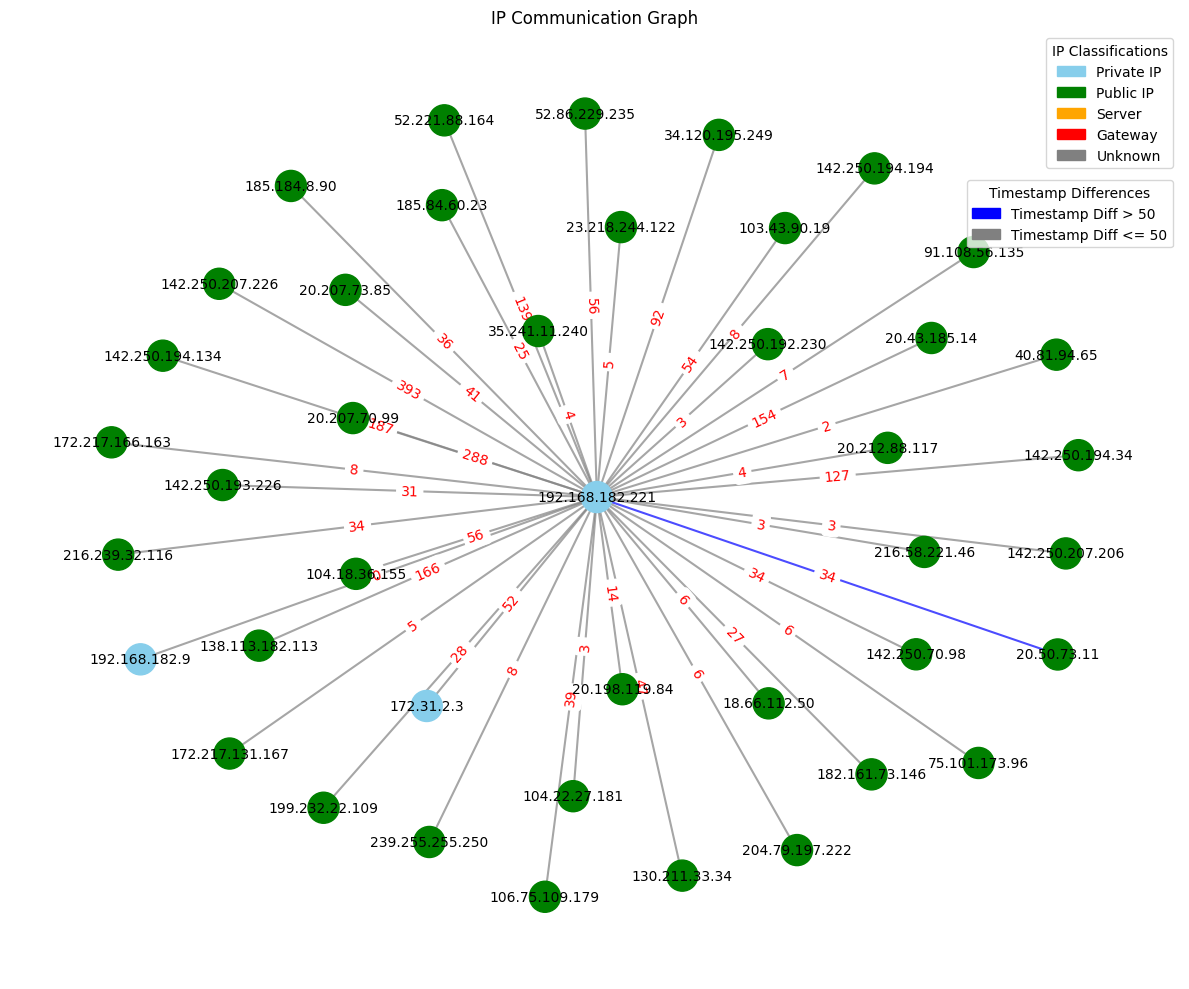

In [4]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import ipaddress
import matplotlib.patches as mpatches

def load_protocol_data(protocol_counts_path):
    return pd.read_csv(protocol_counts_path)

def plot_protocol_distribution_with_table(protocol_counts_df):
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plotting the barplot
    sns.barplot(data=protocol_counts_df, x='Protocol', y='Count', ax=ax)
    ax.set_title('Protocol Distribution')
    ax.set_xlabel('Protocol')
    ax.set_ylabel('Count')

    # Adding the table
    table_data = protocol_counts_df.values
    table = plt.table(cellText=table_data, colLabels=protocol_counts_df.columns, cellLoc='center', loc='bottom', bbox=[0, -0.4, 1, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)

    plt.subplots_adjust(left=0.2, bottom=0.5)
    plt.show()

def load_ip_data(ip_communication_protocols_path):
    return pd.read_csv(ip_communication_protocols_path)

def classify_ip(ip):
    try:
        ip_obj = ipaddress.ip_address(ip)
        if ip_obj.is_private:
            return 'private'
        if ip_obj in ipaddress.ip_network('192.168.1.0/24'):
            return 'server'
        if ip == '192.168.0.1':
            return 'gateway'
        return 'public'
    except ValueError:
        return 'unknown'

def create_ip_communication_graph(ip_communication_protocols, packet_loss_df):
    G = nx.Graph()
    for index, row in ip_communication_protocols.iterrows():
        source_ip = row['Source IP']
        dest_ip = row['Destination IP']
        protocol = row['Protocol']
        count = row['Count']

        source_class = classify_ip(source_ip)
        dest_class = classify_ip(dest_ip)

        if not G.has_node(source_ip):
            G.add_node(source_ip, classification=source_class)
        if not G.has_node(dest_ip):
            G.add_node(dest_ip, classification=dest_class)

        if G.has_edge(source_ip, dest_ip):
            G[source_ip][dest_ip]['count'] += count
        else:
            G.add_edge(source_ip, dest_ip, count=count, protocol=protocol, timestamp_diff=0)

    # Update the edges with timestamp differences from packet_loss_df
    for _, row in packet_loss_df.iterrows():
        src = row['Source ID']
        dst = row['Destination IP']
        timestamp_diff = row['Timestamp Difference']
        if G.has_edge(src, dst):
            G[src][dst]['timestamp_diff'] = timestamp_diff

    return G

def draw_graph(G):
    color_map = {
        'private': 'skyblue',
        'public': 'green',
        'server': 'orange',
        'gateway': 'red',
        'unknown': 'gray'
    }

    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, k=0.15, iterations=20)

    node_colors = [color_map[G.nodes[node]['classification']] for node in G.nodes]
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors)

    edge_colors = ['blue' if d['timestamp_diff'] > 50 else 'gray' for u, v, d in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, alpha=0.7, edge_color=edge_colors, width=1.5)

    edge_labels = {(u, v): d['count'] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=10)
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

    # Separate legends for IP classifications and timestamp differences
    legend_handles_ip = [
        mpatches.Patch(color=color_map['private'], label='Private IP'),
        mpatches.Patch(color=color_map['public'], label='Public IP'),
        mpatches.Patch(color=color_map['server'], label='Server'),
        mpatches.Patch(color=color_map['gateway'], label='Gateway'),
        mpatches.Patch(color=color_map['unknown'], label='Unknown')
    ]
    legend_handles_timestamp = [
        mpatches.Patch(color='blue', label='Timestamp Diff > 50'),
        mpatches.Patch(color='gray', label='Timestamp Diff <= 50')
    ]

    # First legend (IP classifications)
    legend1 = plt.legend(handles=legend_handles_ip, loc='upper right', title='IP Classifications')
    plt.gca().add_artist(legend1)

    # Second legend (timestamp differences)
    plt.legend(handles=legend_handles_timestamp, loc='upper right', bbox_to_anchor=(1, 0.85), title='Timestamp Differences')

    plt.title('IP Communication Graph')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def load_packet_loss_data(packet_loss_path):
    return pd.read_csv(packet_loss_path)

def plot_packet_loss_table(packet_loss_df):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('tight')
    ax.axis('off')
    packet_loss_df.columns = ['Source ID', 'Destination IP', 'Timestamp Difference']
    table = ax.table(cellText=packet_loss_df.values, colLabels=packet_loss_df.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    plt.title('Packet Loss Data', pad=20)
    plt.subplots_adjust(left=0.2, bottom=0.2)
    plt.show()

def draw_ip_communication_table(ip_communication_protocols_df):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=ip_communication_protocols_df.values, colLabels=ip_communication_protocols_df.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    plt.title('IP Communication Protocols', pad=20)
    plt.subplots_adjust(left=0.2, bottom=0.2)
    plt.show()

def main(protocol_counts_path, ip_communication_protocols_path, packet_loss_path):
    protocol_counts_df = load_protocol_data(protocol_counts_path)
    plot_protocol_distribution_with_table(protocol_counts_df)

    ip_communication_protocols = load_ip_data(ip_communication_protocols_path)

    # Draw IP communication protocols table
    draw_ip_communication_table(ip_communication_protocols)

    # Load and plot packet loss data
    packet_loss_df = load_packet_loss_data(packet_loss_path)
    plot_packet_loss_table(packet_loss_df)

    G = create_ip_communication_graph(ip_communication_protocols, packet_loss_df)
    draw_graph(G)

if __name__ == "__main__":
    protocol_counts_path = "protocol_counts.csv"
    ip_communication_protocols_path = "ip_communication_protocols.csv"
    packet_loss_path = "packet_loss.csv"
    main(protocol_counts_path, ip_communication_protocols_path, packet_loss_path)
